In [1]:
import gzip
from itertools import islice

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from Bio.SeqIO import parse, read
from tqdm.notebook import tqdm

from debruijn import Assembler

# Сборка геномов с помощью графов Де Брюйна

Проверять алгоритм будем на 5 наборах синтетических данных: от самых простых к сложным, и на одном наборе реальных данных

## Test 0
Genome length: 12bp

Reads: all 3-mers exactly once

No errors

In [2]:
genome_filename = 'test/genome_0.fasta'
reads_filename = 'test/reads_0.fasta'

genome_seq = read(genome_filename, format='fasta').seq
genome_seq

Seq('AGAATTCCCCAA')

In [3]:
! head {reads_filename}

>0
ATT
>1
GAA
>2
TCC
>3
AAT
>4
AGA


Graph size: 8 nodes and 9 edges


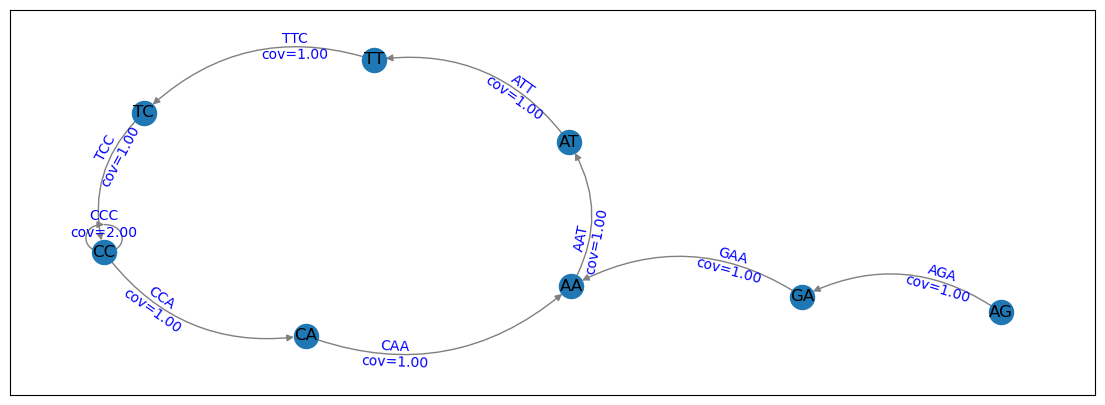

In [4]:
assembler = Assembler(k=3)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads)

assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 5))

Упростим граф, сократив неразветвляющиеся пути

Graph size: 3 nodes and 4 edges


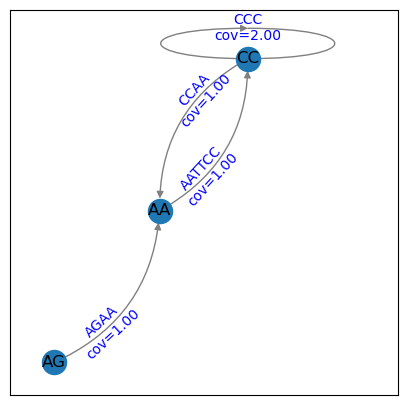

In [5]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(5, 5))

Собралось хорошо, можно визуально выделить максимальный Эйлеров путь, который в точности даст исходный геном

## Test 1

Genome length: 300bp

Reads: Random position and length (20 - 40bp)

Coverage: 10

No errors

In [6]:
genome_filename = 'test/genome_1.fasta'
reads_filename = 'test/reads_1.fasta'

genome_seq = read(genome_filename, format='fasta').seq
genome_seq

Seq('CGCATGGAATACGCGGTTAACTCTGCCATTCCTTATAACTCTTCGTTCTTTTTC...CCG')

In [7]:
! head {reads_filename}

>0
AATGTAGCCCACATACAGACATCGC
>1
TGCCATTCCTTATAACTCTTCGTTCTTTTTCACAAT
>2
AACCGCTACATTGAAAAAGG
>3
AATGTAGCCCACATACAGACATCGCCAGCC
>4
CTTTTTCACAATAGAACCGCTACATTGAAAAAGGTG


В этот раз риды длиннее, можно использовать `k` побольше

In [8]:
assembler = Assembler(k=9)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads)

assembler.print_graph_size()

Graph size: 284 nodes and 284 edges


Graph size: 3 nodes and 3 edges


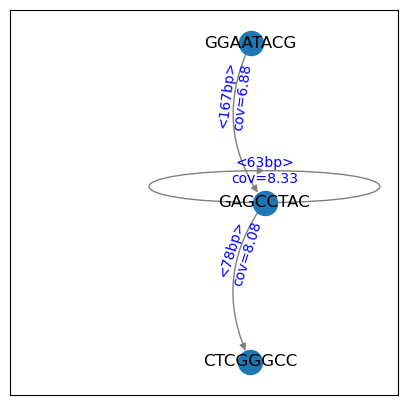

In [9]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(5, 5))

Опять же, собралось хорошо.
Если принять, что среднее покрытие 7-8, то по каждому ребру нужно пройти однократно. Можно визуально выделить максимальный Эйлеров путь, который даст исходный геном без коротких фрагментов с концов. Видимо, они не отсеквенировались

Можно и увеличить `k`. Так, при `k = 11` всё уже собирается до единственного контига

Graph size: 2 nodes and 1 edges


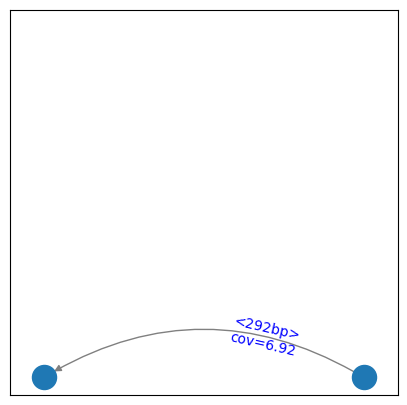

In [10]:
assembler = Assembler(k=11)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads)

assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(5, 5))

In [11]:
contigs = assembler.get_contigs()
cov, contig = contigs[0]

print(contig)
print(f'Contig correct: {genome_seq.find(contig) != -1}')

GGAATACGCGGTTAACTCTGCCATTCCTTATAACTCTTCGTTCTTTTTCACAATAGAACCGCTACATTGAAAAAGGTGTCTGTGGCTATGACGTGGTGTCCGATTGGAGAAAACAGAATATACTAAGTTGGGACCGTTTCGATATTAGGTATTTAAACGGAGCCTACCGCAGGAAGTGATTGGTGTAGCGATTTACTACAATCGGTGCCCGAATGAGCCTACAGCCGTAGTTTAATGTATAATGTAGCCCACATACAGACATCGCCAGCCACGTTTTCAAGGCCCTCGGGCC
Contig correct: True


## Test 2

Genome length: 1000bp

Reads: Random position and length (40 - 60bp)

Coverage: 20

Errors: 0.1%

In [12]:
genome_filename = 'test/genome_2.fasta'
reads_filename = 'test/reads_2.fasta'

genome_seq = read(genome_filename, format='fasta').seq
genome_seq

Seq('GGTCTGTGTGGCGTTGTGAGGTCTGACCCGGGTTAGGAATAGGTGTGGAATATA...AAT')

In [13]:
! head {reads_filename}

>0
ACCTGATTTTCTTGGTGTTCTAACGAAGAGACTCTCCACACCACTATTGAAGCTCTAC
>1
GTTCTAACGAAGAGACTCTCCACACCACTATTGAAGCTCTACGACCATCTACTGGGGC
>2
TACAGGCTCCTACGCAACTTACTGTGTAATGTTTTGCGGAAGTCCGTTAGAAGG
>3
TACGACCATCTACTGGGGCCGTATTCGCGAGCATACTTCTTTATGCCGT
>4
CACACCACTATTGAAGCTCTACGACCATCTACTGGGGCCGTATTCGCGAGCATACT


In [14]:
assembler = Assembler(k=21)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads)

assembler.print_graph_size()

Graph size: 1149 nodes and 1149 edges


Graph size: 30 nodes and 30 edges


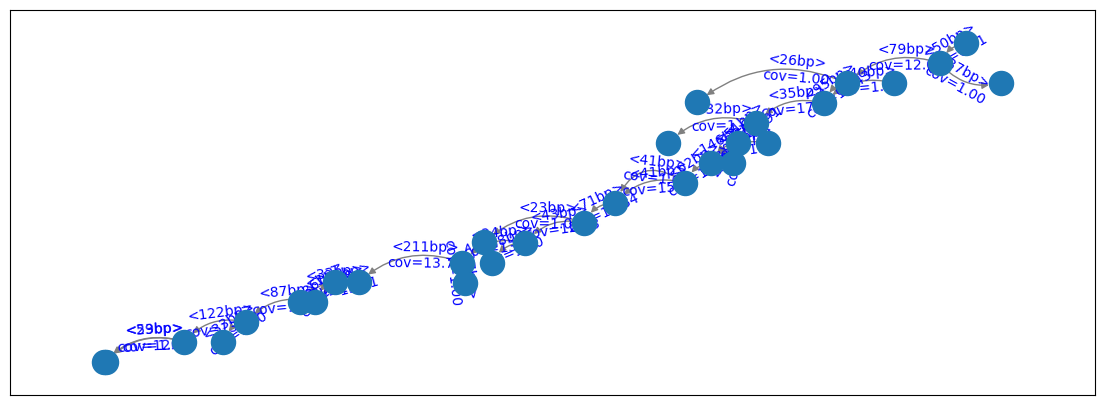

In [15]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 5))

Теперь у нас риды с ошибками, поэтому граф нужно чистить. Посмотрим, есть ли слабо покрытые хвосты

In [16]:
pd.DataFrame(assembler.get_tails(), columns=['Length', 'Coverage', 'Seq'])

,Length,Coverage,Seq
0,26,1.000000,CAACTTACTGTGTAATGTTTCGCGGA
1,23,1.000000,GACCATCTACTGGGGCCGTACTC
2,59,12.643873,GACCATCTACTGGGGCCGTATTCGCGAGCATACTTCTTTATGCCGT...
3,23,1.000000,CATGGGCCAGTATGCTCAGCGCG
4,37,1.000000,GGTTAGGAATAGGTGTGGAAGATACTACCCTTGGATT
5,40,1.000000,CATGCCCTGATCGACGACACCAAGAGGTCTTTGGAAGGAA
6,32,1.000000,AGGAATGAGAAGAATGTGTTAAATACGCAACT
7,50,6.709596,GGTCTGTGTGGCGTTGTGAGGTCTGACCCGGGTTAGGAATAGGTGT...
8,35,1.000000,TCACGGAAACTAGAAGACGTCCTTAAAGCCAGTGT
9,37,1.000000,TCTACATGCCTTGCCAGCGATTCGTAGGAGATCCATA


Удалим слабо покрытые хвосты

Graph size: 17 nodes and 17 edges


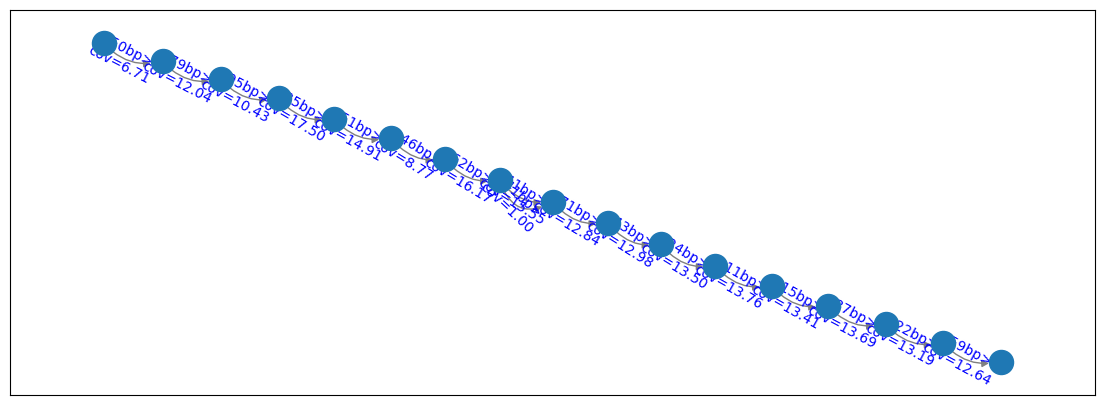

In [17]:
assembler.cut_tails()
assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 5))

После удаления хвостов граф снова нуждается в сжатии

Graph size: 4 nodes and 4 edges


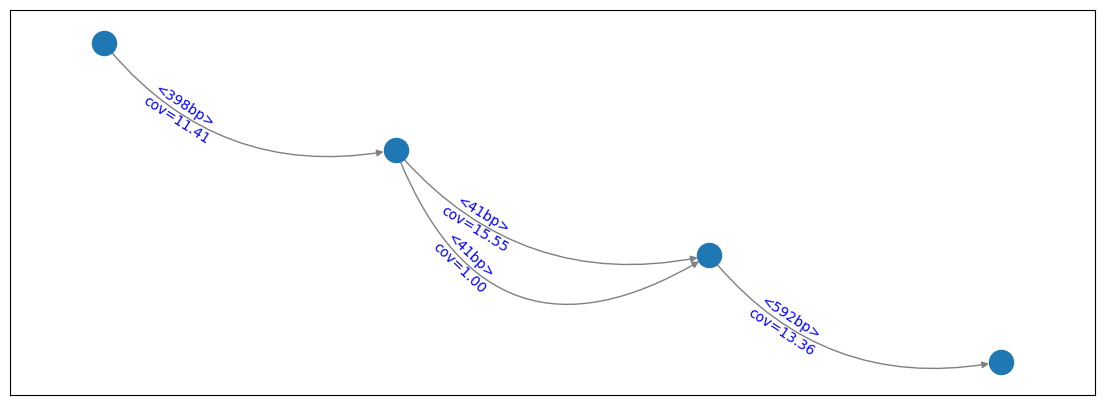

In [18]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 5))

Видим, что остался ещё один пузырь из-за ошибок в ридах. Удалим и его

Graph size: 2 nodes and 1 edges


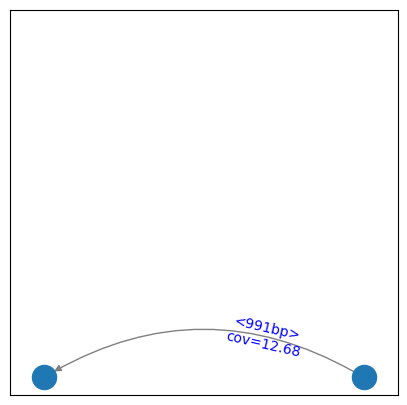

In [19]:
assembler.burst_bubbles()
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(5, 5))

Сборка завершена успешно

In [20]:
contigs = assembler.get_contigs()
cov, contig = contigs[0]

print(f'Contig correct: {genome_seq.find(contig) != -1}')

Contig correct: True


In [21]:
contig

'GGTCTGTGTGGCGTTGTGAGGTCTGACCCGGGTTAGGAATAGGTGTGGAATATACTACCCTTGGATTCTGAAGGGTACAGGCTCCTACGCAACTTACTGTGTAATGTTTTGCGGAAGTCCGTTAGAAGGACTTCGCGATATTCCCATGCCCTGATCGACGACATCAAGAGGTCTTTGGAAGGAATGAGAAGAATGTGTTCAATACGCAACTCACGGAAACTAGAAGACGTGCTTAAAGCCAGTGTGTAGTGAGGCGCATTTGTTGGCTCACACAGAGGCATCCCGGGGCCAGATAGAAGTTAACGTCCTCAGAGGTATTCTCTAACCCTTCACTGGAAGGCCAATGGTGCTGATGTTATGATACGCTAGCGTGGACGAGTACAGATCGTGATTAATTCATTACTCGACAGAATCGGGGGAGAGGCAGCAAAGCGCTCGCCCTCCGGGAATCATGGGCCAGTATGCTCAGCACGTTAGTCTACATGCCTTGCCAGCGACTCGTAGGAGATCCATAGCGACATTCGCAGCTCTGAGTAGGACACTTGGAATGAGTAATACCAGTGTCAGTATCTGGTCCTAGGAACGTCCTGGCAGCACCGTAGTCAATCTACCCGATACCGTCGGGGATCGCGCTGCGTCCGGGCGCGCCTGCACACGATGCTTGCCTCAACGATGTCGAGAAACGTCGTTTGCACCGGACCAGTGGAAACGTTTCAAAGCACGGAGTCCAAGTTGACAAGTGACCCGATCGCTGGAGCTTTCAGCTGACGCGGCGACGGATCAAAGTGAAGCTAGTTATTCGTCTGGGGGAATGATCGCTGGGAGTCAGATTCGTAACCTCCGCGTGACTGAGCCGCCCCAATCGGTGCCACGGACCTGATTTTCTTGGTGTTCTAACGAAGAGACTCTCCACACCACTATTGAAGCTCTACGACCATCTACTGGGGCCGTATTCGCGAGCATACTTCTTTATGCCGTACGAAAACCGATT'

## Test 3

Genome length: 100_000bp

Reads: Random position and length (150 - 250bp)

Coverage: 40

Errors: 0.1%

In [22]:
genome_filename = 'test/genome_3.fasta'
reads_filename = 'test/reads_3.fasta'

genome_seq = read(genome_filename, format='fasta').seq
genome_seq

Seq('TCCCGGGTGTACCCAAGCAGTTGGCGACTTAGCTTTGATTTCGCTCAGATATTG...CCT')

In [23]:
! head {reads_filename}

>0
TTAACGCGGTTTACTTGGTAGAGAATTTCTACGCTCCTGCACTTTGTCCTGAATAATTTT
GTAACCCACGTGGGGTATTCCAATTAATAGTATCTGGATGACAATTTGATAAGCACAGCC
GAGGCTCTCACACTCGTAAGGTTTAGAATCACCATAACTTACGCGCGAGATTCCGGGACG
CT
>1
TCAGACACGTGAATCCGTACTTTATTGAACATCGTTATAATAAGCTAAATAGAGCATACA
CTCCGCGGTGTGTGCGCAATCCCAGTAGGTCTCACGTTCAACATAACGACCTCACCCACA
CTGATCATCTTAACGAGAAGCCGTAGGCGCACTACTTGCTTGCGGTTCCTTAGCACTTTT
ACAGGAATCGTCATCTAGATCAGACTAGCCGCTGGTCGG


In [24]:
assembler = Assembler(k=41)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads, verbose=True)

assembler.print_graph_size()

20000it [00:05, 3623.27it/s]


Graph size: 194680 nodes and 196428 edges


In [25]:
assembler.compactify(verbose=True)
assembler.cut_tails()
assembler.burst_bubbles()
assembler.compactify()
assembler.print_graph_size()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194680/194680 [00:01<00:00, 117180.70it/s]


Graph size: 2963 nodes and 4455 edges


Не смотря на все упрощения, граф остался слишком большим. Можно убедиться, что просто увеличение `k` не исправит ситуацию. Чтобы понять, что же не так, посмотрим на распределение покрытия рёбер

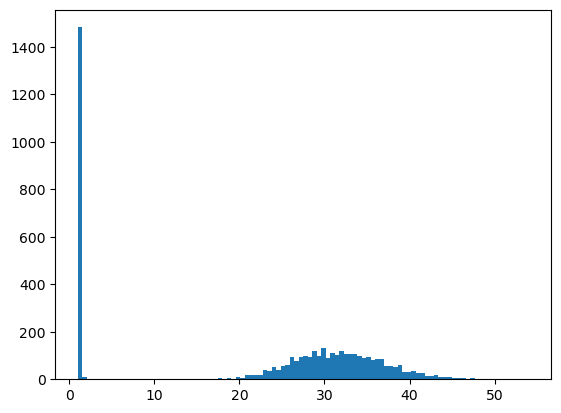

In [26]:
edge_coverage = [cov for cov, seq in assembler.get_edges()]
plt.hist(edge_coverage, bins=100)
plt.show()

Явно видно, что среднее покрытие в графе от 20 до 40, но присутствует большое количество рёбер с очень маленьким покрытием. Вероятно, это не устранённые ошибки секвенирования. Удалим такие рёбра

In [27]:
assembler.drop_low_covered_edges(cov_thres=3.0)

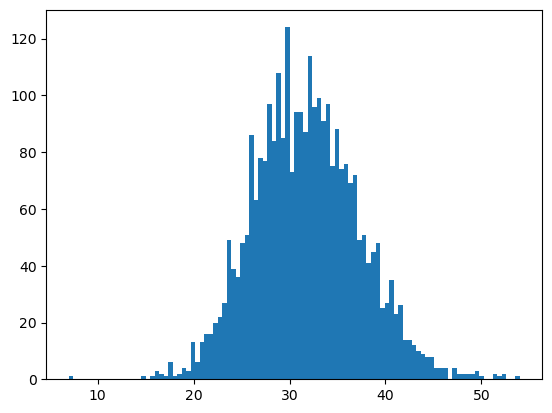

In [28]:
edge_coverage = [cov for cov, seq in assembler.get_edges()]
plt.hist(edge_coverage, bins=100)
plt.show()

Теперь картина лучше. Упрощаем граф

Graph size: 2 nodes and 1 edges


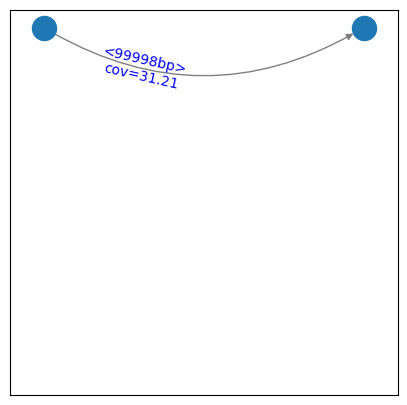

In [29]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(5, 5))

Сборка завершена успешно

In [30]:
contigs = assembler.get_contigs()
cov, contig = contigs[0]

print(f'Contig correct: {genome_seq.find(contig) != -1}')

Contig correct: True


## Test 4

Genome:

        1 chromosome 1Mbp with different number and lengths of
                          repeating regions

        2 plasmids 10Kbp  with some common regions and genes
                          in one and two copies respectively
                          0.1% mutations between copies of same plasmid

        2 plasmids 2Kbp   in one and three copies respectively
                          0.05% mutations between copies of same plasmid

Reads: Random position, length 200bp

Coverage: 40

Errors: 0.05%

In [31]:
genome_filename = 'test/genome_4.fasta'
reads_filename = 'test/reads_4.fasta'

genome_seqs = list(parse(genome_filename, format='fasta'))

for record in genome_seqs:
    print(record)

ID: chromosome
Name: chromosome
Description: chromosome 1000000bp
Number of features: 0
Seq('CGTGTTACCGAAAATGATATTGAGTATTGTTTCAGCAGACAATTAGTATTGCCG...ATC')
ID: plasmid1
Name: plasmid1
Description: plasmid1 10000bp
Number of features: 0
Seq('GCATTCGTGGGCGGAACACGAACCCCCTTGCCGCAACATGTCGCCTAATAGCAC...AAG')
ID: plasmid2_1
Name: plasmid2_1
Description: plasmid2_1 10000bp
Number of features: 0
Seq('AGGTATCTCCTTTATCAGCCTGAATGCGTCAAGCTTACCTCAATTTACCTCAAT...TAC')
ID: plasmid2_2
Name: plasmid2_2
Description: plasmid2_2 10000bp
Number of features: 0
Seq('AGGTATCTCCTTTATCAGCCTGAATGCGTCAAGCTTACCTCAATTTACCTCAAT...TAC')
ID: plasmid3
Name: plasmid3
Description: plasmid3 2000bp
Number of features: 0
Seq('TAAGCAGTTTCGAGTTTTCCGTCTTGTCTACATACCGGGCCAGGCGGAATATCT...AAC')
ID: plasmid4_1
Name: plasmid4_1
Description: plasmid4_1 2000bp
Number of features: 0
Seq('AGGGAGATGATAATGAGTCGACCGTAACCCGCGCACGATAGGGTATACATGGTC...TTC')
ID: plasmid4_2
Name: plasmid4_2
Description: plasmid4_2 2000bp
Number of features: 0
Seq

In [32]:
! head {reads_filename}

>0
GGCGATTTATTCTACTCCCCTGCTACAATTTACCGGTCAACGTTGGTTCTCGTTTAATGC
ACCTTCGAAGGAGGATTTGCGAGACCCGTTTTGTGGCGCATTAGCTTAGTGAATAAATCC
ATCAAGGAAGGACCAAGAAGACGTGAATCGGGGTGCGCTACTACGGCTTACGACAAAGCC
AGATTATTTACGGGCGGGGA
>1
TCGAAAGAGATCCGAGATGTCCGCGGTGAACAGCCGTTGCCAGTTGTTCCGATCGGACAG
AATCTAAATGGGTCGTGGACTACGCGTTAATGACGGAATCACAGGTCTCTAGCGCGCGCG
TTAATCGGGGTAGCAGCTGCGAACAAGCTACCCCGGTTGGGGTAAATCAACACCTTTTCA
ATGTAATTAACCCGCTGTTA


In [33]:
assembler = Assembler(k=91)

with open(reads_filename, 'r') as f_in:
    reads = (record.seq for record in parse(f_in, 'fasta'))
    assembler.build_graph(reads, verbose=True)

assembler.print_graph_size()

200000it [00:43, 4603.16it/s]


Graph size: 1742294 nodes and 1743684 edges


In [34]:
assembler.compactify(verbose=True)
assembler.cut_tails()
assembler.burst_bubbles()
assembler.compactify()
assembler.print_graph_size()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1742294/1742294 [00:17<00:00, 97893.80it/s]


Graph size: 2322 nodes and 3356 edges


Удаляем рёбра с низким покрытием

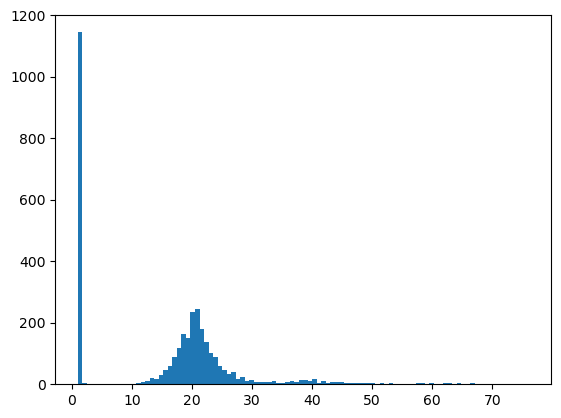

In [35]:
edge_coverage = [cov for cov, seq in assembler.get_edges()]
plt.hist(edge_coverage, bins=100)
plt.show()

In [36]:
assembler.drop_low_covered_edges(cov_thres=3.0)

Из-за повторов в геноме есть участки с двойным и тройным покрытием. Но среднее покрытие однократных участков около 20

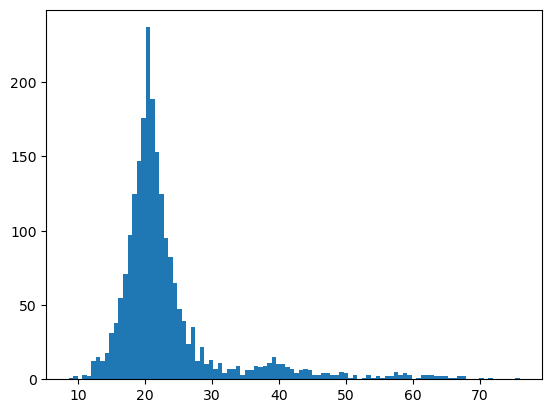

In [37]:
edge_coverage = [cov for cov, seq in assembler.get_edges()]
plt.hist(edge_coverage, bins=100)
plt.show()

Graph size: 28 nodes and 40 edges


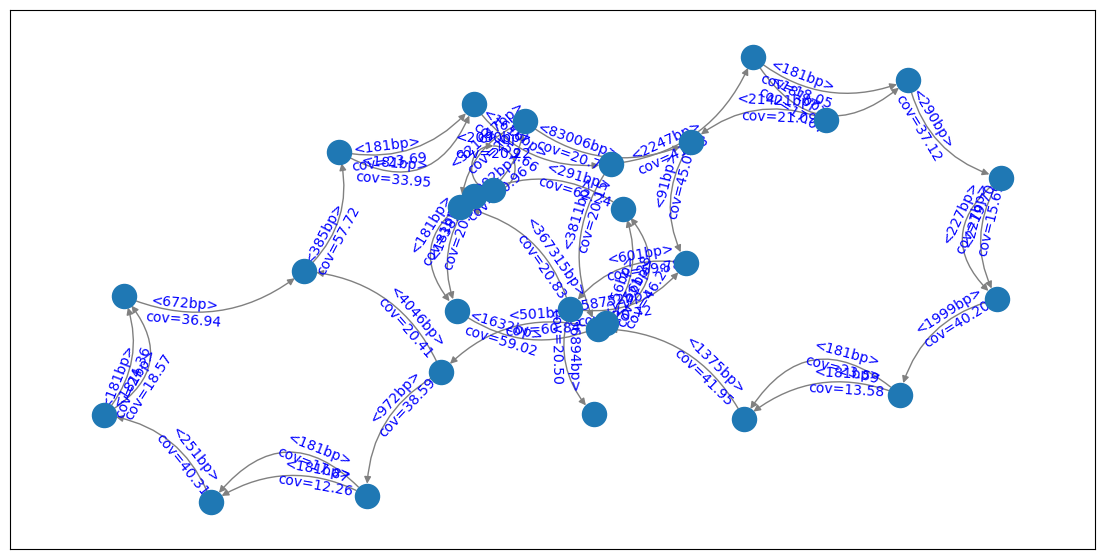

In [38]:
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 7))

Граф можно ещё упростить

Graph size: 14 nodes and 26 edges


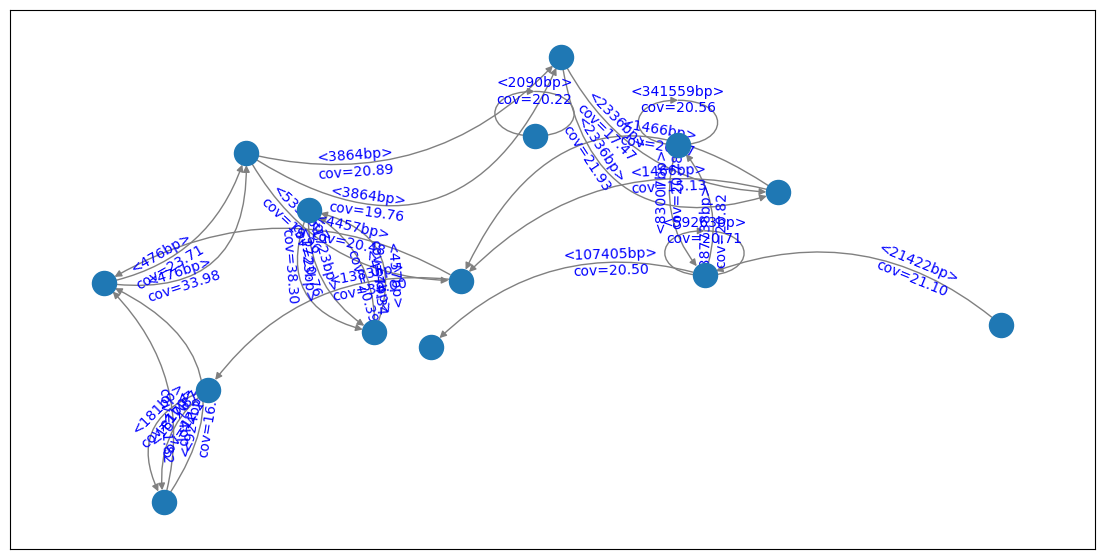

In [39]:
assembler.local_resolve(avg_cov=20.0)
assembler.compactify()
assembler.print_graph_size()
assembler.plot_graph(figsize=(14, 7))

Граф выглядит сложно. Проанализируем его компоненты связности по отдельности

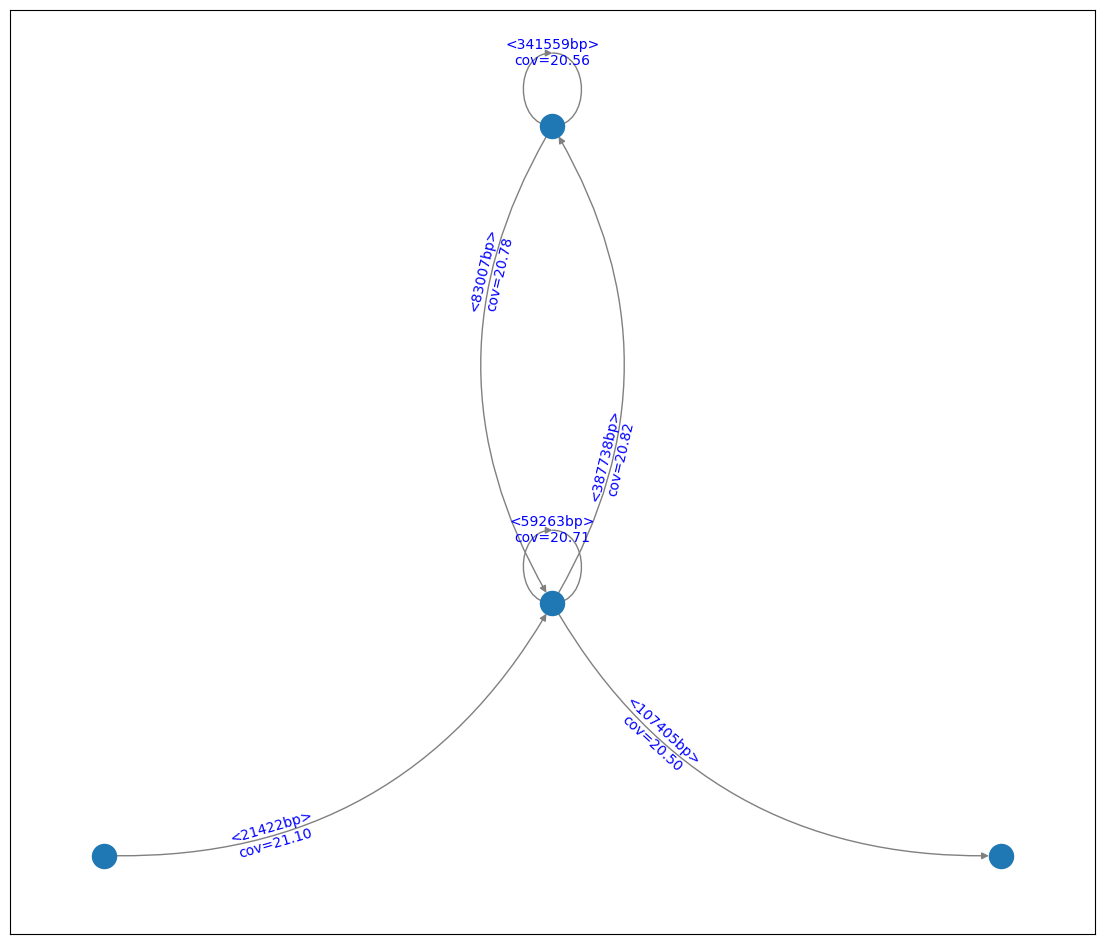

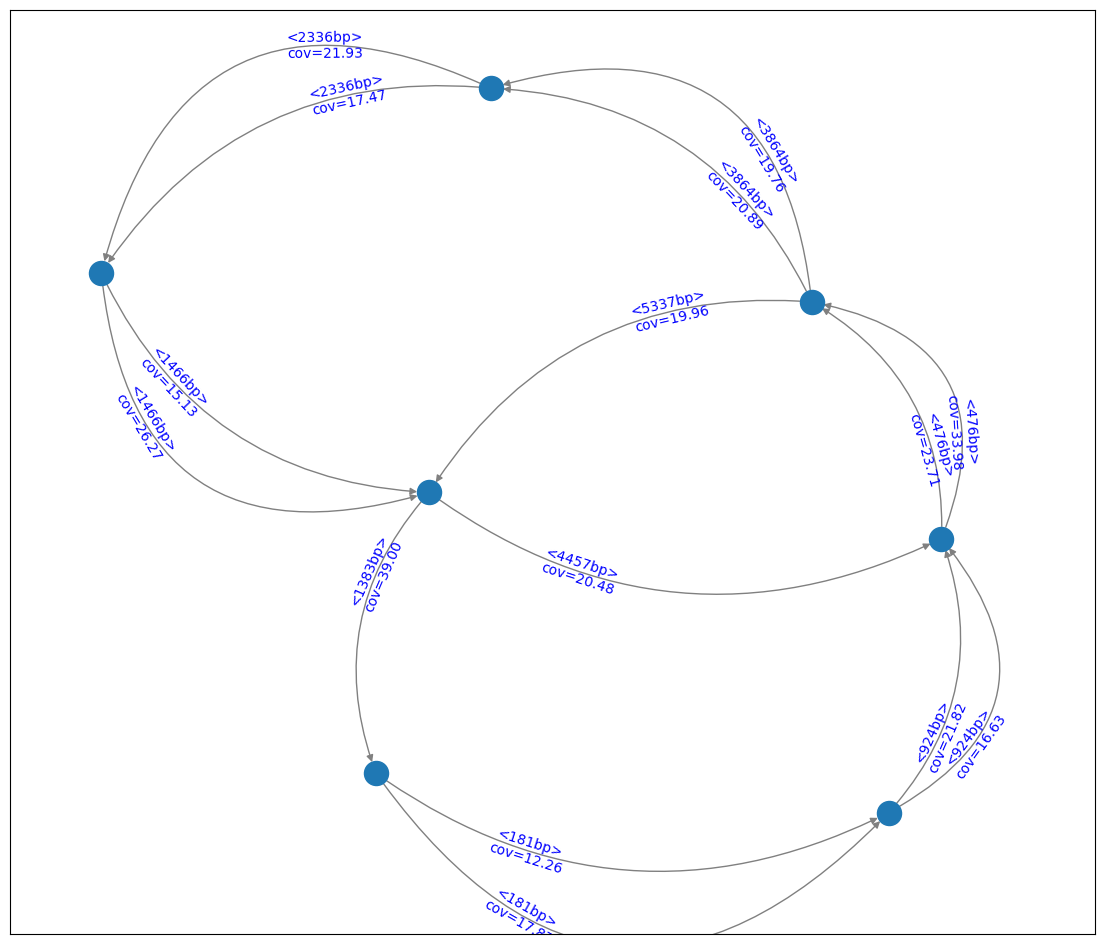

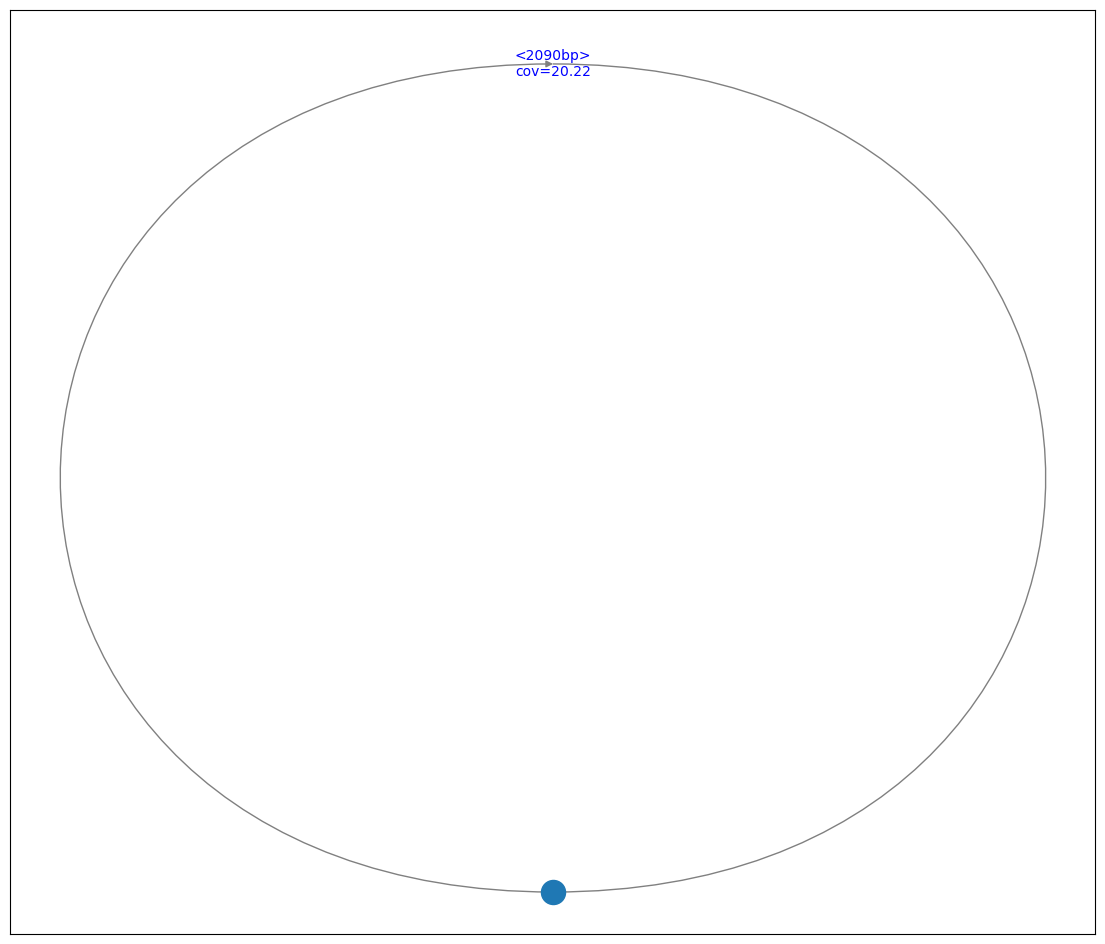

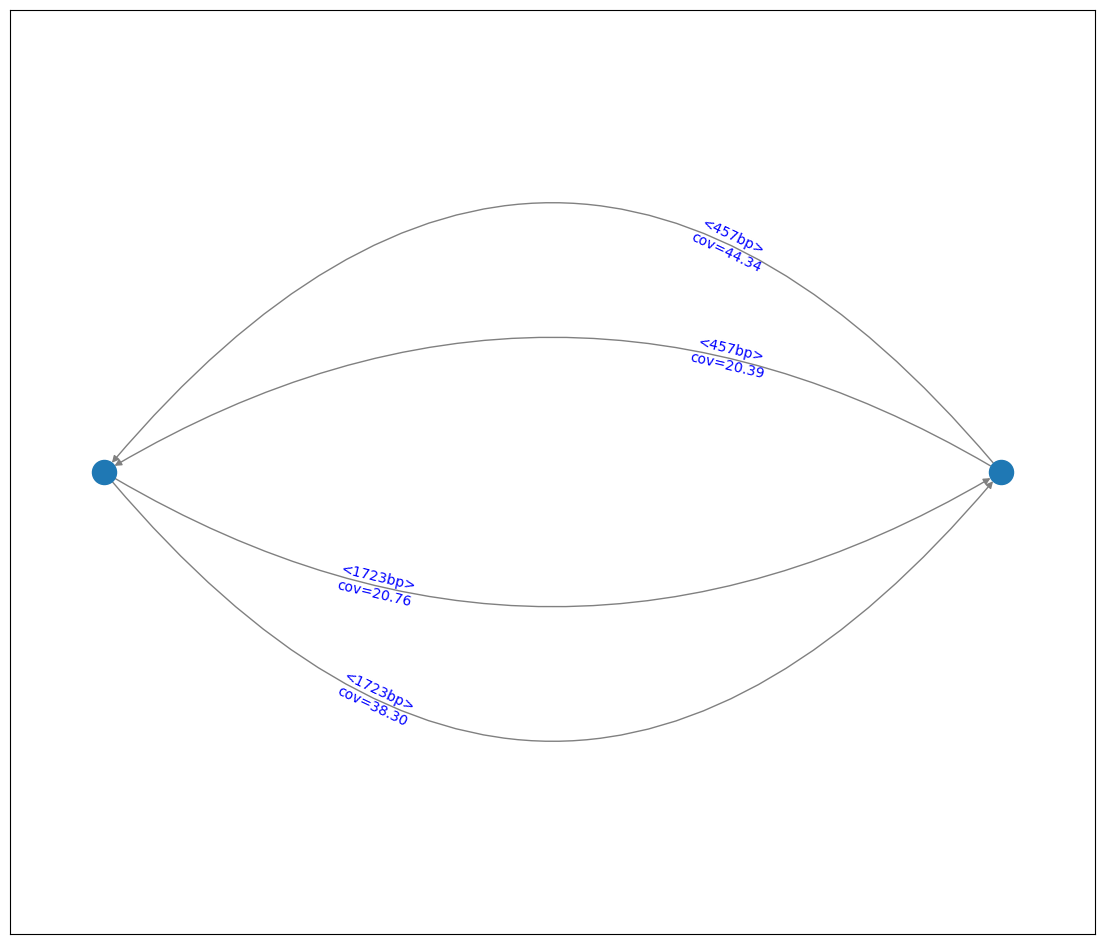

In [40]:
assembler.plot_graph_componentwise(figsize=(14, 12))

- Первая компонента связности — хромосома.
- Вторая, по видимому, — две большие плазмиды.
- Третья компонента связности — плазмида_3, собралась идеально.
- Четвёртая — плазмида_4, из-за мутаций между копиями мы видим хорошо покрытые параллельные рёбра

## Тестирование на реальных данных

In [2]:
reads_filename = 'test/ERR008613.fastq.gz'

In [52]:
! fastqc {reads_filename}

application/gzip
Started analysis of ERR008613.fastq.gz
Approx 5% complete for ERR008613.fastq.gz
Approx 10% complete for ERR008613.fastq.gz
Approx 15% complete for ERR008613.fastq.gz
Approx 20% complete for ERR008613.fastq.gz
Approx 25% complete for ERR008613.fastq.gz
Approx 30% complete for ERR008613.fastq.gz
Approx 35% complete for ERR008613.fastq.gz
Approx 40% complete for ERR008613.fastq.gz
Approx 45% complete for ERR008613.fastq.gz
Approx 50% complete for ERR008613.fastq.gz
Approx 55% complete for ERR008613.fastq.gz
Approx 60% complete for ERR008613.fastq.gz
Approx 65% complete for ERR008613.fastq.gz
Approx 70% complete for ERR008613.fastq.gz
Approx 75% complete for ERR008613.fastq.gz
Approx 80% complete for ERR008613.fastq.gz
Approx 85% complete for ERR008613.fastq.gz
Approx 90% complete for ERR008613.fastq.gz
Approx 95% complete for ERR008613.fastq.gz
Analysis complete for ERR008613.fastq.gz


In [3]:
reads_trimmed_filename = 'test/ERR008613_trimmed.fastq.gz'

In [56]:
! trimmomatic SE -threads 8 -phred33 {reads_filename} {reads_trimmed_filename} ILLUMINACLIP:TruSeq3-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36

TrimmomaticSE: Started with arguments:
 -threads 8 -phred33 test/ERR008613.fastq.gz test/ERR008613_trimmed.fastq.gz ILLUMINACLIP:TruSeq3-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36
Using Long Clipping Sequence: 'AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA'
Using Long Clipping Sequence: 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC'
ILLUMINACLIP: Using 0 prefix pairs, 2 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Input Reads: 28428648 Surviving: 28404998 (99.92%) Dropped: 23650 (0.08%)
TrimmomaticSE: Completed successfully


In [4]:
def check_read(seq):
    for ch in seq:
        if ch not in set('ATGC'):
            return False
    return True

In [5]:
assembler = Assembler(k=51)

In [6]:
with gzip.open(reads_trimmed_filename, 'rt') as f_in:
    reads = (record.seq for record in parse(f_in, 'fastq') if check_read(record.seq))
    assembler.build_graph(islice(reads, 0, 300_000), verbose=True)

assembler.print_graph_size()

300000it [00:57, 5179.59it/s]


Graph size: 9239917 nodes and 9154477 edges


In [8]:
assembler.compactify(verbose=True)
assembler.print_graph_size()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9239917/9239917 [01:38<00:00, 94220.12it/s]


Graph size: 321930 nodes and 236490 edges


In [10]:
assembler.cut_tails()
assembler.burst_bubbles()
assembler.compactify()
assembler.print_graph_size()

Graph size: 138053 nodes and 69832 edges


In [13]:
contigs = assembler.get_contigs()
contigs = sorted(contigs, key=lambda x: len(x[1]), reverse=True)
contigs[:5]

[(4.9757917830839045,
  'TCCCATAAGCGCTAACTTAAGGGTTGAACCATCTGAAGAATGCGACGCCTCGGTGCCTCGTTAAGACGATGCCTCGCGTTCTTCAATTGCGTTTTGTAGGCTGTCAGGGATACTGTCCCACGAATGGCCACCTGTAAGCTCCAGATGACCATTTTTGTTATTCTCCACAACGAGTTAGTTCTTCTTTTCGGATCCGGCACTTCTGGGGGGGAAATCCAGCGATGGCTGGATTATGTCGTCAATTAAAAATGCGGCGAGTAGATTAGCAAATATCCACGCTTTCGCGAGTTCAGGTTCCTTTGCACGCAAAGCATCCAGGTGCAGCAAACTTTTGAGCCGCTTAAAAGCCAGTTCAATTTGCCATCGCAGACGGTAACAATCAGCCACTTGCTCTGCTGAATATTCATCTTCCGGTAATGATGTTAGCAATAGCACATGGCCCGCTGCTTCCAGCGTTTCCGCCTGAACTACTCGTCCTTTTCGACGATTCTCGCTGAGCAGTCGGGTTTTACTGATTAATGCTTTTTCGGGAGGAAGTGATACGGCAATGAGACGTGCCGGAAAGGGAGCTCCGGCTTTTTTATTACCTGAATTGCCTATCATTACAGTGGTTTCACCGTTCTTACCGCAATCCAGCCCGCGCAGAAAACCCATCATGTCAAAGCGCATTCCTTCTGCAGTTAACCAGCGCAATCCTCGCCAGTGAACCCGGACGATATAATCAGCTTCTCCAAAAGCAAGTGAGCGGATACATTCGGGACGCGAACCGAATCCCCGGTCAGCAATGCGTATCTCGTCTGCCGTTTGCGCAAATCGGTCCAGCCGTTCAGCGTCTCTGCTGTCGGTTAGCTCAAAATCAGTGAACTGACAGGTATGAGGATCATATCCCATATGTAGTCGCCATTCAGCGCTGCCGCCCCCGGGCGCACTGATTGCTGTTCCATCGACAAGACGCAATCTCTTTCCGCTTGTACA